The purpose of this notebook is to tune video parameters, such as grayscale, resolution, cropping and sampling, and visualize the accuracy of these adjustments to understand the tradeoffs associated between quality and accuracy in the context of recognizing cars passing in a lane from a traffic video feed. The clip used these adjustments is tcam.mp4 (https://www.dropbox.com/s/91t6ucfsq9u9vca/tcam.mp4?dl=0).

First, make all necessary imports:

In [70]:
from dlcv.struct import *
from dlcv.utils import *
from dlcv.dataflow.map import *
from dlcv.dataflow.agg import *
from dlcv.tracking.contour import *
from dlcv.tracking.event import *

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

Using sklearn, we'll define functions that, given features and labels, will create regressions that can predict data. We will define a linear regression function and a polynomial regression function and use these to visualize data

In [12]:
def createLinearReg(features, labels):
    model = LinearRegression()
    model.fit(features, labels)
    return model

# default we create a quadratic model
def createPolyReg(features, labels, degree):
    features_poly = PolynomialFeatures(degree=degree).fit_transform(features)
    model = LinearRegression()
    model.fit(features_poly, labels)
    return model, features_poly

**Measuring baseline:** We'll first analyze the car count in the **left lane**. This is the baseline car count (highest quality) using a limit of n frames.

In [63]:
frames = 1000
v = VideoStream('tcam.mp4', limit = frames)
region = Box(200,550,350,750)
pipeline = v[KeyPoints()][ActivityMetric('one', region)][Filter('one', [-0.25,-0.25,1,-0.25,-0.25],1.5, delay=10)]
baseCars, stats = count(pipeline, ['one'], stats=True)
print('[Left] Car count is', baseCars['one'])
print('Stats on the analysis:', stats)

[Left] Car count is 16
Stats on the analysis: {'frames': 1001, 'elapsed': 17.82805895805359}


**Cropping:** Let's consider the effect of cropping the area of frame analyzed on overall accuracy. This is a bit subjective to test (as we can crop in infinitely many ways) so the methodology here is to crop relative to the box. Our cropping samples will always be centered around and proportional to the target region.

In [21]:
croppings = np.arange(0, 275, 25)
croppingSizes = []
croppingAccuracies = []

for c in np.nditer(croppings):
    k = KeyPoints()
    x1, y1, x2, y2 = c, c + 350, 550 - c, 1150 - (2*c)
    croppingSizes.append((x2 - x1) * (y2 - y1))
    k.setCrop(Box(x1, y1, x2, y2))
    pipeline = v[k][ActivityMetric('one', region)][Filter('one', [-0.25,-0.25,1,-0.25,-0.25],1.5, delay=10)]
    carCount = count(pipeline, ['one'])['one']
    accuracy = carCount / baseCars['one'] if (carCount <= baseCars['one']) else max(carCount - (carCount - baseCars['one']), 0) / baseCars['one'] 
    croppingAccuracies.append(accuracy)

In [51]:
croppingSizes = np.asarray(croppingSizes).flatten()[:,np.newaxis]
croppingAccuracies = np.asarray(croppingAccuracies)

cropLinearReg = createLinearReg(croppingSizes, croppingAccuracies)
crop2Reg, cropSizePoly2 = createPolyReg(croppingSizes, croppingAccuracies, 2)
crop3Reg, cropSizePoly3 = createPolyReg(croppingSizes, croppingAccuracies, 3)
crop4Reg, cropSizePoly4 = createPolyReg(croppingSizes, croppingAccuracies, 4)
cropLinearPred = cropLinearReg.predict(croppingSizes)
crop2Pred = crop2Reg.predict(cropSizePoly2)
crop3Pred = crop3Reg.predict(cropSizePoly3)
crop4Pred = crop4Reg.predict(cropSizePoly4)

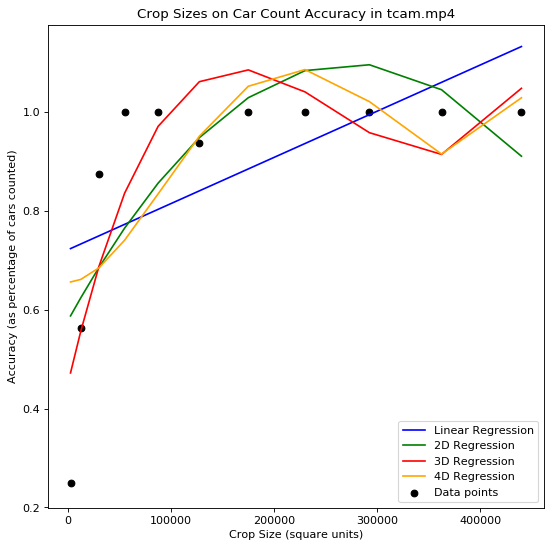

In [52]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(croppingSizes, croppingAccuracies, color='black', label='Data points')
plt.plot(croppingSizes, cropLinearPred, color='blue', linestyle='solid', linewidth=1.5, label='Linear Regression')
plt.plot(croppingSizes, crop2Pred, color='green', linestyle='solid', linewidth=1.5, label='2D Regression')
plt.plot(croppingSizes, crop3Pred, color='red', linestyle='solid', linewidth=1.5, label='3D Regression')
plt.plot(croppingSizes, crop4Pred, color='orange', linestyle='solid', linewidth=1.5, label='4D Regression')
plt.legend(loc='lower right')
plt.title("Crop Sizes on Car Count Accuracy in tcam.mp4")
plt.xlabel('Crop Size (square units)')
plt.ylabel('Accuracy (as percentage of cars counted)')
plt.show()

In [31]:
rmse1 = np.sqrt(mean_squared_error(croppingAccuracies,cropLinearPred))
rmse2 = np.sqrt(mean_squared_error(croppingAccuracies,crop2Pred))
rmse3 = np.sqrt(mean_squared_error(croppingAccuracies,crop3Pred))
rmse4 = np.sqrt(mean_squared_error(croppingAccuracies,crop4Pred))

print("The RMSE for the 1D regression model is:", rmse1)
print("The RMSE for the 2D regression model is:", rmse2)
print("The RMSE for the 3D regression model is:", rmse3)
print("The RMSE for the 4D regression model is:", rmse4)

The RMSE for the 1D regression model is: 0.19248755522124844
The RMSE for the 2D regression model is: 0.15275937840498238
The RMSE for the 3D regression model is: 0.1160408724959248
The RMSE for the 4D regression model is: 0.17173146797535366


**Sampling:** Let's consider the effect of only analyzing a specified proportion of frames on overall accuracy.

In [53]:
samplings = np.arange(.05, 1, .05)
samplingReg = samplings[:,np.newaxis]
samplingAccuracies = []
for s in np.nditer(samplings):
    pipeline = v[Sample(s)][KeyPoints()][ActivityMetric('one', region)][Filter('one', [-0.25,-0.25,1,-0.25,-0.25],1.5, delay=10)]
    samplingAccuracies.append(count(pipeline, ['one'])['one'] / baseCars['one'])

In [54]:
samplingAccuracies = np.asarray(samplingAccuracies)
samplingLinearReg = createLinearReg(samplingReg, samplingAccuracies)
sampling2Reg, samplingSizePoly2 = createPolyReg(samplingReg, samplingAccuracies, 2)
sampling3Reg, samplingSizePoly3 = createPolyReg(samplingReg, samplingAccuracies, 3)
sampling4Reg, samplingSizePoly4 = createPolyReg(samplingReg, samplingAccuracies, 4)
samplingLinearPred = samplingLinearReg.predict(samplingReg)
sampling2Pred = sampling2Reg.predict(samplingSizePoly2)
sampling3Pred = sampling3Reg.predict(samplingSizePoly3)
sampling4Pred = sampling4Reg.predict(samplingSizePoly4)

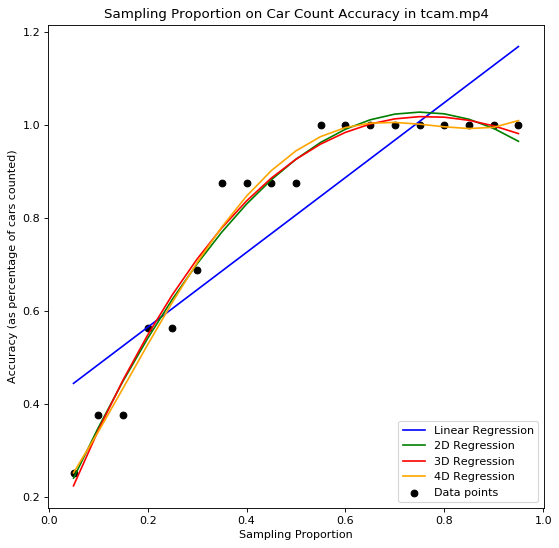

In [55]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(samplings, samplingAccuracies, color='black', label='Data points')
plt.plot(samplings, samplingLinearPred, color='blue', linestyle='solid', linewidth=1.5, label='Linear Regression')
plt.plot(samplings, sampling2Pred, color='green', linestyle='solid', linewidth=1.5, label='2D Regression')
plt.plot(samplings, sampling3Pred, color='red', linestyle='solid', linewidth=1.5, label='3D Regression')
plt.plot(samplings, sampling4Pred, color='orange', linestyle='solid', linewidth=1.5, label='4D Regression')
plt.legend(loc='lower right')
plt.title("Sampling Proportion on Car Count Accuracy in tcam.mp4")
plt.xlabel('Sampling Proportion')
plt.ylabel('Accuracy (as percentage of cars counted)')
plt.show()

In [56]:
rmse1 = np.sqrt(mean_squared_error(samplingAccuracies,samplingLinearPred))
rmse2 = np.sqrt(mean_squared_error(samplingAccuracies,sampling2Pred))
rmse3 = np.sqrt(mean_squared_error(samplingAccuracies,sampling3Pred))
rmse4 = np.sqrt(mean_squared_error(samplingAccuracies,sampling4Pred))

print("The RMSE for the 1D regression model is:", rmse1)
print("The RMSE for the 2D regression model is:", rmse2)
print("The RMSE for the 3D regression model is:", rmse3)
print("The RMSE for the 4D regression model is:", rmse4)

The RMSE for the 1D regression model is: 0.11425259704967168
The RMSE for the 2D regression model is: 0.04076571787816507
The RMSE for the 3D regression model is: 0.03984778329900856
The RMSE for the 4D regression model is: 0.036564446884011566


**Grayscale:** Let's consider the effect of changing grayscale on overall accuracy.

In [72]:
frames = 1000
v = VideoStream('tcam.mp4', limit = frames)
region = Box(200,550,350,750)
pipeline = v[Grayscale()][KeyPoints()][ActivityMetric('one', region)][Filter('one', [-0.25,-0.25,1,-0.25,-0.25],1.5, delay=10)]

grayScaleCars, grayScaleStats = count(pipeline, ['one'], stats=True)
# print('[Left] Car count is', grayScaleCars['one'])
# print('Stats on the analysis:', grayScaleStats)

error: OpenCV(4.1.0) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<1, -1, -1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>, cv::impl::(anonymous namespace)::SizePolicy::NONE>::CvtHelper(InputArray, OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDcn = cv::impl::(anonymous namespace)::Set<1, -1, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::SizePolicy::NONE]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


**Resolution:** Let's consider the effect of changing the resolution on overall accuracy.

In [34]:
resolutions = np.arange(.5, 1.5, .1)
resolutionReg = resolutions[:,np.newaxis]
resolutionAccuracies = []
for r in np.nditer(resolutions):
    pipeline = v[Resize(r)][KeyPoints()][ActivityMetric('one', region)][Filter('one', [-0.25,-0.25,1,-0.25,-0.25],1.5, delay=10)]
    resolutionAccuracies.append(count(pipeline, ['one'])['one'] / baseCars['one'])

In [47]:
resolutionAccuracies = np.asarray(resolutionAccuracies)

resolutionLinearReg = createLinearReg(resolutionReg, resolutionAccuracies)
resolution2Reg, resolutionPoly2  = createPolyReg(resolutionReg, resolutionAccuracies, 2)
resolution3Reg, resolutionPoly3  = createPolyReg(resolutionReg, resolutionAccuracies, 3)
resolution4Reg, resolutionPoly4  = createPolyReg(resolutionReg, resolutionAccuracies, 4)
resolution5Reg, resolutionPoly5  = createPolyReg(resolutionReg, resolutionAccuracies, 5)
resolutionLinearPred = resolutionLinearReg.predict(resolutionReg)
resolution2Pred = resolution2Reg.predict(resolutionPoly2)
resolution3Pred = resolution3Reg.predict(resolutionPoly3)
resolution4Pred = resolution4Reg.predict(resolutionPoly4)
resolution5Pred = resolution5Reg.predict(resolutionPoly5)

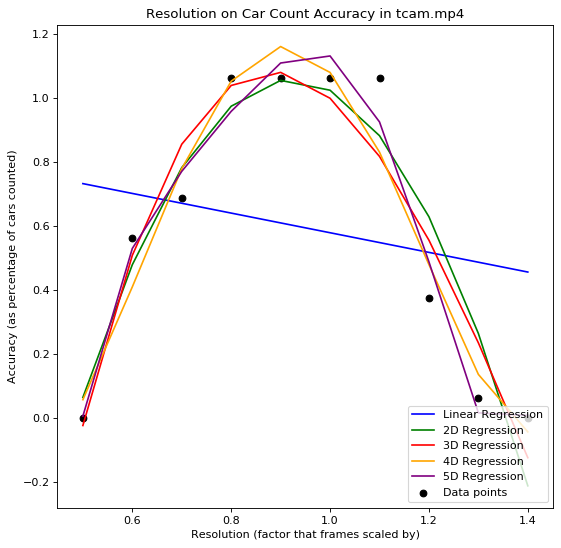

In [50]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(resolutions, resolutionAccuracies, color='black', label='Data points')
plt.plot(resolutions, resolutionLinearPred, color='blue', linestyle='solid', linewidth=1.5, label='Linear Regression')
plt.plot(resolutions, resolution2Pred, color='green', linestyle='solid', linewidth=1.5, label='2D Regression')
plt.plot(resolutions, resolution3Pred, color='red', linestyle='solid', linewidth=1.5, label='3D Regression')
plt.plot(resolutions, resolution4Pred, color='orange', linestyle='solid', linewidth=1.5, label='4D Regression')
plt.plot(resolutions, resolution5Pred, color='purple', linestyle='solid', linewidth=1.5, label='5D Regression')
plt.legend(loc='lower right')
plt.title('Resolution on Car Count Accuracy in tcam.mp4')
plt.xlabel('Resolution (factor that frames scaled by)')
plt.ylabel('Accuracy (as percentage of cars counted)')
plt.show()

In [49]:
rmse1 = np.sqrt(mean_squared_error(resolutionAccuracies,resolutionLinearPred))
rmse2 = np.sqrt(mean_squared_error(resolutionAccuracies,resolution2Pred))
rmse3 = np.sqrt(mean_squared_error(resolutionAccuracies,resolution3Pred))
rmse4 = np.sqrt(mean_squared_error(resolutionAccuracies,resolution4Pred))
rmse5 = np.sqrt(mean_squared_error(resolutionAccuracies,resolution5Pred))

print("The RMSE for the 1D regression model is:", rmse1)
print("The RMSE for the 2D regression model is:", rmse2)
print("The RMSE for the 3D regression model is:", rmse3)
print("The RMSE for the 4D regression model is:", rmse4)
print("The RMSE for the 5D regression model is:", rmse5)

The RMSE for the 1D regression model is: 0.4296701959325632
The RMSE for the 2D regression model is: 0.14556861797062867
The RMSE for the 3D regression model is: 0.1320612623386942
The RMSE for the 4D regression model is: 0.10816797773528891
The RMSE for the 5D regression model is: 0.07724401290158424
